In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from xgboost import XGBRegressor

In [71]:
mat_file = "../data/student-mat.csv"
por_file = "../data/student-por.csv"

mat_df = pd.read_csv(mat_file, sep=";")
por_df = pd.read_csv(por_file, sep=";")

#creating catagorical columns list and numeric columns list
cat_columns = ['school','sex','address','famsize','Pstatus','Mjob','Fjob','reason','guardian',
                'schoolsup','famsup','paid','activities','nursery','higher','internet','romantic']

num_columns = ['Medu','Fedu','traveltime','studytime','famrel','freetime','goout','Dalc','Walc','health']
cont_columns = ['age','failures','absences','G1','G2','G3']

In [72]:
# Define the preprocessor with OneHotEncoder
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_columns),
        ('num', StandardScaler(), num_columns + cont_columns[:-1])
    ],
    remainder='passthrough'
)

# Function to preprocess the dataset
def preprocess_data(df):
    X = df.drop('G3', axis=1)
    y = df['G3']
    X = preprocessor.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test, preprocessor

# Preprocess both datasets
X_mat_train, X_mat_test, y_mat_train, y_mat_test, preprocessor_mat = preprocess_data(mat_df)
X_por_train, X_por_test, y_por_train, y_por_test, preprocessor_por = preprocess_data(por_df)

In [73]:
# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

# Function to evaluate model
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    rmse = np.sqrt(mse)
    r2_train = model.score(X_train, y_train)
    r2_test = model.score(X_test, y_test)
    adj_r2_train = 1 - (1 - r2_train) * (len(y_train) - 1) / (len(y_train) - X_train.shape[1] - 1)
    adj_r2_test = 1 - (1 - r2_test) * (len(y_test) - 1) / (len(y_test) - X_test.shape[1] - 1)
    cv_scores = cross_val_score(model, np.vstack((X_train, X_test)), np.hstack((y_train, y_test)), cv=5, scoring='r2')
    return rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, np.mean(cv_scores)

# Perform grid search for hyperparameter tuning
param_grids = {
    'Decision Tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10, 20]
    },
    'Random Forest': {
        'n_estimators': [100, 200, 500],
        'max_features': ['sqrt', 'log2'],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 500],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7]
    }
}

Math Results Table:
               Model      RMSE  R2 (Training)  Adjusted R2 (Training)  \
0  Linear Regression  2.378370       0.865598                0.845486   
1      Decision Tree  2.324879       1.000000                1.000000   
2      Random Forest  2.146061       0.965647                0.960506   
3            XGBoost  1.949039       0.974733                0.970952   

   R2 (Test)  Adjusted R2 (Test)  5-Fold CV Mean R2  
0   0.724134            0.418445           0.791629  
1   0.736403            0.444310           0.815552  
2   0.775393            0.526504           0.771872  
3   0.814741            0.609453           0.865342  
Portuguese Results Table:
               Model      RMSE  R2 (Training)  Adjusted R2 (Training)  \
0  Linear Regression  1.214870       0.858337                0.846160   
1      Decision Tree  1.477207       0.889331                0.879819   
2      Random Forest  1.426215       0.968660                0.965967   
3            XGBoost  1.23

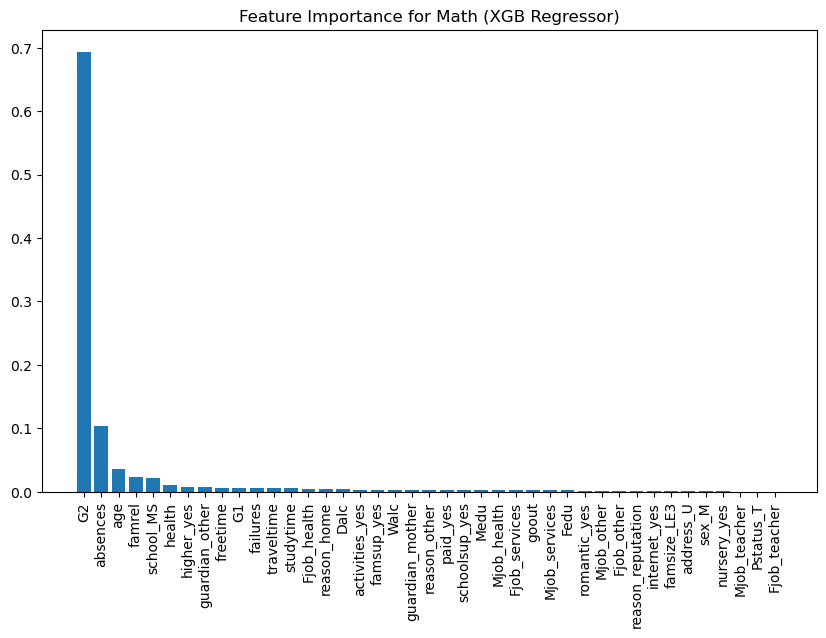

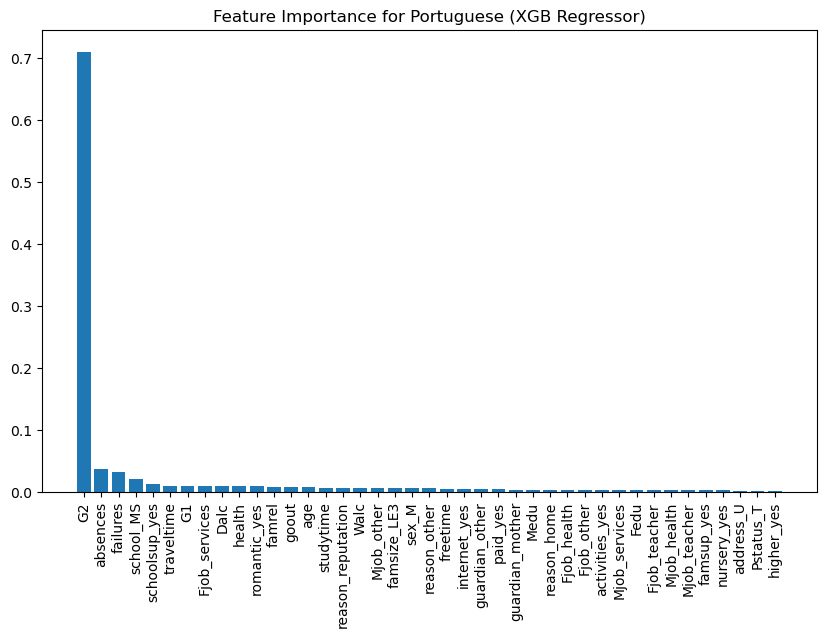

In [75]:
# Evaluate models and perform hyperparameter tuning
results_mat = {}
results_por = {}

for name, model in models.items():
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='r2', n_jobs=-1)
        rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, cv_mean = evaluate_model(grid_search, X_mat_train, y_mat_train, X_mat_test, y_mat_test)
        results_mat[name] = {'RMSE': rmse, 'R2_train': r2_train, 'Adj_R2_train': adj_r2_train, 'R2_test': r2_test, 'Adj_R2_test': adj_r2_test, 'CV_mean': cv_mean}
        
        rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, cv_mean = evaluate_model(grid_search, X_por_train, y_por_train, X_por_test, y_por_test)
        results_por[name] = {'RMSE': rmse, 'R2_train': r2_train, 'Adj_R2_train': adj_r2_train, 'R2_test': r2_test, 'Adj_R2_test': adj_r2_test, 'CV_mean': cv_mean}
    else:
        rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, cv_mean = evaluate_model(model, X_mat_train, y_mat_train, X_mat_test, y_mat_test)
        results_mat[name] = {'RMSE': rmse, 'R2_train': r2_train, 'Adj_R2_train': adj_r2_train, 'R2_test': r2_test, 'Adj_R2_test': adj_r2_test, 'CV_mean': cv_mean}
        
        rmse, r2_train, adj_r2_train, r2_test, adj_r2_test, cv_mean = evaluate_model(model, X_por_train, y_por_train, X_por_test, y_por_test)
        results_por[name] = {'RMSE': rmse, 'R2_train': r2_train, 'Adj_R2_train': adj_r2_train, 'R2_test': r2_test, 'Adj_R2_test': adj_r2_test, 'CV_mean': cv_mean}

# Feature importance for XGboost
def plot_feature_importance(model, X_train, y_train, preprocessor, all_features, title):
    # Apply preprocessor to the training data
    X_train_transformed = preprocessor.fit_transform(X_train)
    
    # Get the correct feature names after preprocessing
    feature_names = preprocessor.get_feature_names_out(all_features)
    
    clean_feature_names = [name.split('__')[-1] for name in feature_names]
    
    # Fit model
    model.fit(X_train_transformed, y_train)
    
    # Get feature importances
    importance = model.feature_importances_
    indices = np.argsort(importance)[::-1]
    
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.bar(range(len(importance)), importance[indices])
    plt.xticks(range(len(importance)), np.array(clean_feature_names)[indices], rotation=90)
    plt.show()


def create_results_table(results):
    data = []
    for model_name, metrics in results.items():
        data.append([
            model_name,
            metrics['RMSE'],
            metrics['R2_train'],
            metrics['Adj_R2_train'],
            metrics['R2_test'],
            metrics['Adj_R2_test'],
            metrics['CV_mean']
        ])
    columns = ['Model', 'RMSE', 'R2 (Training)', 'Adjusted R2 (Training)', 'R2 (Test)', 'Adjusted R2 (Test)', '5-Fold CV Mean R2']
    return pd.DataFrame(data, columns=columns)

results_table_mat = create_results_table(results_mat)
results_table_por = create_results_table(results_por)

print("Math Results Table:")
print(results_table_mat)

print("Portuguese Results Table:")
print(results_table_por)

# Plot feature importance for Math and Portuguese using XGBRegressor
plot_feature_importance(XGBRegressor(), mat_df.drop('G3', axis=1), mat_df['G3'], preprocessor_mat, mat_df.drop('G3', axis=1).columns, "Feature Importance for Math (XGB Regressor)")
plot_feature_importance(XGBRegressor(), por_df.drop('G3', axis=1), por_df['G3'], preprocessor_mat, por_df.drop('G3', axis=1).columns, "Feature Importance for Portuguese (XGB Regressor)")